# SE-2200E Notebook 4: A First Prediction

Ningsong Shen

February 18, 2021

## Summary

Using our cleaned data, we separate into train, test, validate sets and run some simple algorithms

## Model Usage
Get a trained model paramaters and use it to predict live data from transit feeds using the AWS vm.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [17]:
df = pd.read_csv('../clean_data/sample_data.csv').drop_duplicates().sort_values(["trip_id", "start_date", "stop_sequence"], ignore_index=True)
df.head(50)

,trip_id,start_date,route_id,stop_sequence,vehicle_id,scheduled_departure_time,real_departure_time
0,1331672,20201105,6,20,3124.0,1297.0,1110.0
1,1331672,20201105,6,21,3124.0,1391.0,1260.0
2,1331672,20201105,6,22,3124.0,1445.0,1297.0
3,1331672,20201105,6,23,3124.0,1560.0,1391.0
4,1331672,20201105,6,24,3124.0,1585.0,1445.0
5,1331672,20201105,6,25,3124.0,1627.0,1560.0
6,1331672,20201105,6,34,3124.0,1997.0,1726.0
7,1331672,20201105,6,35,3124.0,2040.0,1829.0
8,1331672,20201106,6,20,3301.0,1297.0,1080.0
9,1331672,20201106,6,21,3301.0,1391.0,1260.0


## A Linear Regression

In [18]:
df.dtypes

trip_id                       int64
start_date                    int64
route_id                      int64
stop_sequence                 int64
vehicle_id                  float64
scheduled_departure_time    float64
real_departure_time         float64
dtype: object

In [19]:
X = df["scheduled_departure_time"].values.reshape(-1, 1)
Y = df["real_departure_time"].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

Text(0, 0.5, 'Actual # of seconds from terminal')

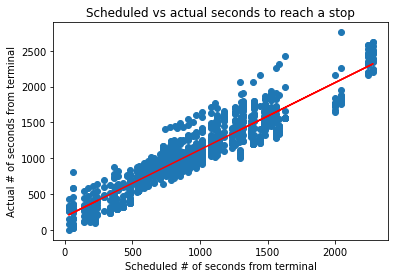

In [20]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title("Scheduled vs actual seconds to reach a stop")
plt.xlabel("Scheduled # of seconds from terminal")
plt.ylabel("Actual # of seconds from terminal")